In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys
import importlib  

import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from sklearn.utils import resample, shuffle

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from pairs_trading_package.clustering import *

import pairs_trading_package as lfl
from pairs_trading_package.utils import flatten, postfix_keys_to_dict, get_current_time_hash, get_random_hash


In [3]:

from pairs_trading_package.pairs_trading_backtester import (
    SeriesAnalyser, DataProcessor
)

data_processor = DataProcessor()

# load etf metadata
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='../data_folder/original/commodity_ETFs_long_updated.xlsx')

# intraday
df_prices = pd.read_pickle('../data_folder/original/commodity_ETFs_from_2014_complete.pickle')

SPLIT_IDX = 2

splits = [ 
    [('01-01-2012', '31-12-2014'), ('01-01-2015', '31-12-2015'), '2014-01-01'],
    [('01-01-2013', '31-12-2015'), ('01-01-2016', '31-12-2016'), '2015-01-01'],
    [('01-01-2014', '31-12-2016'), ('01-01-2017', '31-12-2017'), '2016-01-01'] 
]

# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices, splits[SPLIT_IDX][0], splits[SPLIT_IDX][1], remove_nan=True)

df_train_returns = data_processor.get_return_series(df_prices_train)#.asfreq('B').dropna()
df_test_returns = data_processor.get_return_series(df_prices_test)#.asfreq('B').dropna()


Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

# Convert string categorical set describing asset sectors/segments to integer.

enc = OrdinalEncoder()

sector_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Sector']

enc.fit(sector_data_df.astype(str).values.reshape(-1, 1))

sector_ground_truth = enc.transform(sector_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)


segment_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Segment']

enc.fit(segment_data_df.astype(str).values.reshape(-1, 1))

segment_ground_truth = enc.transform(segment_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)

In [5]:
assigned_labels_pca = []
assigned_labels_ae = []

In [6]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA

kmeans_algo_pca_template = {'init':['k-means++'], 'n_clusters': [46], 'n_init': [20]}
kmeans_algo_ae_template = {'init':['k-means++'], 'n_clusters': [30], 'n_init': [20]}


# GET VALUES FOR PCA

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df_train_returns)

pca_instance = PCA(n_components=25)

reduced_data = pca_instance.fit_transform(scaled_data)

feature_df = pd.DataFrame(pca_instance.components_, columns=df_train_returns.columns).T

km_clustered_series_all, km_clustered_series, km_counts, assigned_labels = series_analyser.apply_clustering_algo('kmeans', feature_df,
                                                                                                        df_train_returns.columns, 
                                                                                                        permute_params(kmeans_algo_pca_template)[0])

assigned_labels_pca.append(assigned_labels)

# GET VALUES FOR AUTOENCODER

for model_identifier in glob.glob('../experiment_3/ae_exhaust/covariance_matrix/embedding_sets/' + str(SPLIT_IDX) + '/*.csv'):

    pre_train_clusterable_feature_df = pd.read_csv(model_identifier).iloc[:, 1:]

    km_clustered_series_all, km_clustered_series, km_counts, _assigned_labels = series_analyser.apply_clustering_algo('kmeans', pre_train_clusterable_feature_df,
                                                                                                            df_train_returns.columns, 
                                                                                                            permute_params(kmeans_algo_ae_template)[0])

    assigned_labels_ae.append(_assigned_labels) 


{'init': 'k-means++', 'n_clusters': 46, 'n_init': 20}
Clusters discovered: 46
Pairs to evaluate: 235
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 319
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 398
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 374
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 404
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 423


In [12]:
from collections import Counter


def get_metrics(labels, ignore_one_sample_cluster=True):
    # K_s be the number of times state s was observed in the sample
    ks_counts = np.asarray(Counter(labels).most_common()) 
    
    if ignore_one_sample_cluster:
        ks_counts = np.array([f for f in ks_counts if f[1] > 1])
    
    # m_k is the number of states s that are sampled exactly k times
    m_k = lambda k : np.sum(ks_counts[:,1].astype(int) == k)
    
    return ks_counts[:,1], np.array([m_k(k) for k in ks_counts[:,1]])

colors = ['b', 'r']
k_list = [[], []]
mk_list = [[], []]

for al_id, al_list in enumerate([assigned_labels_ae, assigned_labels_pca]):
    for assigned_labs in al_list:

        series_assigned_labels = pd.Series(assigned_labs)

        k, mk = get_metrics(series_assigned_labels)
        
        k_list[al_id].append(k)
        mk_list[al_id].append(mk)


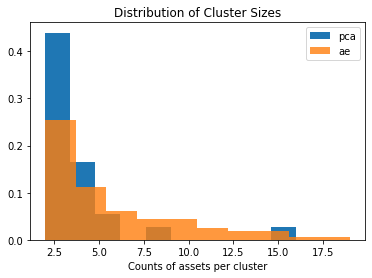

In [13]:

plt.hist(flatten(k_list[1]), label='pca', density=True, bins=10)
plt.hist(flatten(k_list[0]), label='ae', alpha=0.8, density=True, bins=10)
plt.xlabel('Counts of assets per cluster')
plt.title('Distribution of Cluster Sizes')
plt.legend()